# Object localization with CNNs 

**Before you start**
* Go to Runtime > Change runtime type to make sure that the hardware accelerator is set to GPU to speed up computations

In this notebook, we will apply convolutional neural networks to the problem of object localization in images. By combining topics from previous notebooks, we'll create a simple CNN that can identify and localize chickens in an image. During training of this CNN, different augmentation methods will be applied in order to improve the generalization capability of the network. This illustrates a typical approach for a real-world CNN application.

After finishing this notebook, you should be able to:
* define, train and use a CNN for object localization
* explain how to use data augmentation for object localization
* explain the effect of geometrical data augmentations on the bounding-box label
* apply data augmentation to boost performance on object localization

In [76]:
!pip install d2l==0.16.1 --quiet

In [77]:
import os 

from d2l import torch as d2l
import torch
import torchvision
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torchvision.transforms.functional import to_tensor, to_pil_image
from torch import nn

import numpy as np

In [78]:
import pandas as pd

# 1: The chicken localization dataset
Let's download and inspect our data. 
* Run the following cell to download the required files. 
* When the cell finished, you can find a new folder `chicken_localization_dataset` in the Files (click folder icon on the left of the window to see it)

In [79]:
# Download the data
!git clone https://git.wur.nl/lampi002/chicken_localization_dataset.git
!ls chicken_localization_dataset

fatal: destination path 'chicken_localization_dataset' already exists and is not an empty directory.
annotations_test.csv	     annotations_train_subset.csv  images
annotations_test_subset.csv  backgrounds		   README.md
annotations_train.csv	     generate_dataset.py


Information about the training data is stored in the file ```annotations_train_subset.csv```. Per line in the file, it contains information about
* The image filename
* The class of the object (always class id 0 in this case as we only consider chickens)
* The x,y,width,height coordinates of the bounding box (in pixels)

Check the first 3 elements of the ```annotations_train_subset.csv``` file to see what it contains. 



In [80]:
with open('chicken_localization_dataset/annotations_train_subset.csv', 'r') as f:
   for index, line in enumerate(f):
     print(line)
     if index == 3:
            break

img_name,label,x,y,w,h

images/train_subset/0_0.png,0,76.5,64.5,101.0,79.0

images/train_subset/1_0.png,0,64.0,64.5,94.0,75.0

images/train_subset/1_1.png,0,64.5,64.5,119.0,85.0



As we are using custom image data, we also need to build a customized dataset class, similar to the dataset classes we have seen in previous notebooks.

**Exercise:**
* Study the code block below. 
* Where is the `annotations_train_subset.csv` or `annotations_test_subset.csv` used?
* What does the `__getitem__` function do? 







In [81]:
class ChickenDataset(Dataset):
    ## Constructor function loading filenames and labels for the training/test set
    def __init__(self, is_train=True, transforms=None):
        self.images = []
        self.boxes = []
        self.transforms = transforms
        annotation_file = os.path.join('chicken_localization_dataset',
                             'annotations_train_subset.csv' if is_train else 'annotations_test_subset.csv')
    
        with open(annotation_file, 'r') as file:
              for index, line in enumerate(file):
                  # Ignore first row as this contains the headers
                  if index >0:
                     annotation = line.rstrip().split(',')
                     image_name = os.path.join('chicken_localization_dataset', annotation[0])
                     box = [float(element) for element in annotation[2:]]
                     
                     # TODO: add your code here (~2 lines)
                     self.images.append(image_name)
                     self.boxes.append(box)

    ## Function returning the number of samples in the dataset    
    def __len__(self):
        return len(self.images)

    ## Function returning the sample (input,output) at index idx. Function loads the image as PIL image
    def __getitem__(self, idx):
        image = d2l.Image.open(self.images[idx])  # Load the image
        box = torch.tensor(self.boxes[idx])       # Put the label (bbox coordinates) in a tensor
     
        if self.transforms is not None:
            image, box = self.transforms(image, box) # Apply data transformations if provided

        return image, box

# Creating training and test datasets
train_dataset = ChickenDataset(is_train=True)
test_dataset = ChickenDataset(is_train=False)

               

Let's get one sample from the training set to see what it is:

Bounding box coordinates: tensor([64.0000, 64.5000, 94.0000, 69.0000])


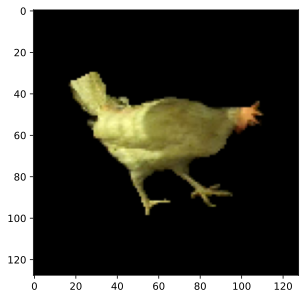

In [82]:
%matplotlib inline
import matplotlib.pyplot as plt

img,bbox = train_dataset[10]

plt.imshow(img)
print('Bounding box coordinates:', bbox)

**Note:** This dataset is artificially created and designed for single object localization tasks. Some chicken images might appear partially visible due to the fact that they were extracted from images containing multiple animals.

The following two functions will be used to plot images and bounding boxes, either for a single image or for a grid of multiple images from the dataset: 

 



In [83]:
def visualize_single_sample(image, bbox, title=""):
    """
    Visualize a single image and bounding box using matplotlib.
    
    Parameters:
        image (PIL image): The input image.
        bbox (list): A list containing the bounding box coordinates (x, y, w, h).
    """
    fig, ax = d2l.plt.subplots()
    ax.imshow(image)
    x, y, w, h = bbox
    rect = d2l.plt.Rectangle(xy=(x-w/2, y-h/2), width=w, height=h,
                                fill=False, edgecolor='blue', linewidth=2)
    ax.add_patch(rect)
    if(title):
      d2l.plt.title(title)
    d2l.plt.show()


def plot_samples(images, labels, nrows, ncols): 
  """
  This function plots a grid of images and their corresponding bounding boxes.
  Parameters:
        - images: list of images 
        - labels: list of bounding box coordinates in form [x, y, w, h] 
        - nrows: the number of rows in the grid
        - ncols: the number of columns in the grid
  """

  fig, axs = d2l.plt.subplots(nrows, ncols, figsize=(15, 6))
  for i in range(ncols*nrows):
      ax = axs[i // ncols][i % ncols]
      image = images[i]
      boxes = [labels[i]]
      ax.imshow(image)
      for box in boxes:
          x, y, w, h = box
          rect = d2l.plt.Rectangle(xy=(x-w/2, y-h/2), width=w, height=h,
                                fill=False, edgecolor='blue', linewidth=2)
          ax.add_patch(rect)
      ax.axis('off')
  d2l.plt.show()


**Exercise:** 
* Use ```visualize_single_sample(image,bbox)``` to visualize the image with the annotated bounding box. Inspect several images from the training set.
* Do the same for the test set
* What differences do you see between the training set and the test set? How could this influence the performance of a neural network trained on the training dataset?


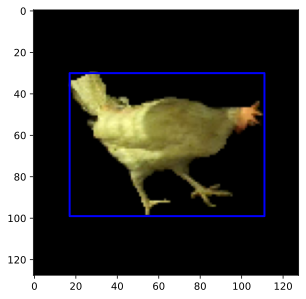

In [84]:
## ANSWER ##
img_id = np.random.randint(len(train_dataset))

# Get image from train_dataset
img,bbox = train_dataset[10]

# Visualize

visualize_single_sample(img, bbox)

**ANSWER:**
* The chicken in the test set are much smaller than in the training set. This will likely result in a poor performance of the network on the test set if trained on this training set. 
* Later in the notebook, you will learn to apply data augmentation to deal with this

# 2: Object localization

In this section, we will build a CNN for object localization. Remember from the MLP tutorial that the task for object localization is to predict the bounding box surrounding the object. A bounding box is determined by four coordinates, the position (x,y), widht, and height.

## 2.1: Build a CNN for object localization 
Now we will implement a convolutional neural network to predict bounding boxes. We will start with the familiar AlexNet model ([8.1 Deep Convolutional Neural Networks](https://d2l.ai/chapter_convolutional-modern/alexnet.html)) as a baseline.

In the image below, you see the AlexNet network architecture modified to deal well with the 128 x 128 image resolution of the chicken dataset. It consists of a number of convolutional and pooling layers, and some fully connected layers at the end.  


<center><img src="https://git.wur.nl/koots006/wias-course-image-and-video-analysis/-/raw/main/day3/alexnet.jpg" width=500></center>

<center><img src="https://git.wur.nl/koots006/wias-course-image-and-video-analysis/-/raw/main/day3/alexnet.png" width=600
00></center>

**Exercise:** 
* Study the code below and compare the implemented network architecture with the one shown in the table and figure. Does it match?
* Notice that the default AlexNet has 1000 output neurons and is made for classification. How should you adapt the network to predict the four coordinates of a bounding box (x,y,w,h)?
* Change the code to do bounding-box regression

| Input | Output |
| --- | --- |

In [85]:
alexnet = nn.Sequential(
            nn.LazyConv2d(96, kernel_size=11, stride=4, padding=4),
            nn.ReLU(), 

            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),

            nn.LazyConv2d(256, kernel_size=5, padding=2), 
            nn.ReLU(),

            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),

            nn.LazyConv2d(384, kernel_size=3, padding=1), 
            nn.ReLU(),

            nn.LazyConv2d(384, kernel_size=3, padding=1), 
            nn.ReLU(),

            nn.LazyConv2d(256, kernel_size=3, padding=1), 
            nn.ReLU(),

            nn.MaxPool2d(kernel_size=3, stride=2, padding=1), 

            nn.Flatten(),

            nn.LazyLinear(4096), 
            nn.ReLU(), 
            nn.Dropout(p=0.5),

            nn.LazyLinear(4096), 
            nn.ReLU(),
            nn.Dropout(p=0.5),
            
            nn.LazyLinear(4)
          )

/home/llan/miniconda3/envs/pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


**Exercise:**
* After defining the axlexnet, we can make a summary of the network architecture using the following code block
* Does the summary table match the table provided above? 

In [86]:
!pip install torch-summary --quiet

In [87]:
from torchsummary import summary

# We need to initialize the lazy modules
alexnet(torch.randn(1,3,128,128))

summary(alexnet, (3, 128, 128), device = 'cpu')

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 96, 32, 32]          34,944
├─ReLU: 1-2                              [-1, 96, 32, 32]          --
├─MaxPool2d: 1-3                         [-1, 96, 16, 16]          --
├─Conv2d: 1-4                            [-1, 256, 16, 16]         614,656
├─ReLU: 1-5                              [-1, 256, 16, 16]         --
├─MaxPool2d: 1-6                         [-1, 256, 8, 8]           --
├─Conv2d: 1-7                            [-1, 384, 8, 8]           885,120
├─ReLU: 1-8                              [-1, 384, 8, 8]           --
├─Conv2d: 1-9                            [-1, 384, 8, 8]           1,327,488
├─ReLU: 1-10                             [-1, 384, 8, 8]           --
├─Conv2d: 1-11                           [-1, 256, 8, 8]           884,992
├─ReLU: 1-12                             [-1, 256, 8, 8]           --
├─MaxPool2d: 1-13                        [-1, 256, 4, 4]   

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 96, 32, 32]          34,944
├─ReLU: 1-2                              [-1, 96, 32, 32]          --
├─MaxPool2d: 1-3                         [-1, 96, 16, 16]          --
├─Conv2d: 1-4                            [-1, 256, 16, 16]         614,656
├─ReLU: 1-5                              [-1, 256, 16, 16]         --
├─MaxPool2d: 1-6                         [-1, 256, 8, 8]           --
├─Conv2d: 1-7                            [-1, 384, 8, 8]           885,120
├─ReLU: 1-8                              [-1, 384, 8, 8]           --
├─Conv2d: 1-9                            [-1, 384, 8, 8]           1,327,488
├─ReLU: 1-10                             [-1, 384, 8, 8]           --
├─Conv2d: 1-11                           [-1, 256, 8, 8]           884,992
├─ReLU: 1-12                             [-1, 256, 8, 8]           --
├─MaxPool2d: 1-13                        [-1, 256, 4, 4]   

Let's initialize the network with random weights:

In [88]:
batch_size, device = 256, d2l.try_gpu()

def init_weights(m):
    if type(m) in [nn.Linear, nn.Conv2d]:
        nn.init.xavier_uniform_(m.weight)

alexnet.apply(init_weights)


Sequential(
  (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4), padding=(4, 4))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (3): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU()
  (10): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU()
  (12): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=4096, out_features=4096, bias=True)
  (15): ReLU()
  (16): Dropout(p=0.5, inplace=False)
  (17): Linear(in_features=4096, out_features=4096, bias=True)
  (18): ReLU()
  (19): Dropout(p=0.5, inplace=False)
  (20): Linear(in_featu

## 2.2: Training AlexNet

In the following code blocks, there are some functions defined to train the network. These are similar to what you have seen before. Some important points:

* We define a class `NoTransform`, which makes sure that the PIL image is changed into a Torch tensor, so that the network can use it to train and predict.
* Two functions to get the training and test dataloaders.
* `train_batch` trains the network on one batch of images
* `evaluate_loss` calculates the loss on the training/test data
* `train` trains the network for `num_epoch` epochs

**Do:**
* Run the code blocks to load all functions


In [89]:
class NoTransform:      
    def __call__(self, img, box):
        img_transformed = transforms.ToTensor()(img)
        box_transformed = box

        return img_transformed, box_transformed

no_aug = NoTransform()

In [90]:
def load_train_data(augs, batch_size):
    dataset = ChickenDataset(is_train=True,transforms=augs)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                    shuffle=True, num_workers=d2l.get_dataloader_workers())
    return dataloader

def load_test_data(augs, batch_size):
    dataset = ChickenDataset(is_train=False,transforms=augs)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                    shuffle=False, num_workers=d2l.get_dataloader_workers())
    return dataloader
    

In [91]:
def train_batch(net, X, y, loss, trainer, device):
    X = X.to(device)
    y = y.to(device)
    net.train()
    trainer.zero_grad()
    pred = net(X)
    l = loss(pred, y)
    l.sum().backward()
    trainer.step()
    train_loss_sum = l.sum()
    return train_loss_sum

def evaluate_loss(net, data_iter, loss, device):
    """Evaluate the loss of a model on the given dataset."""
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        X, y = X.to(device), y.to(device)
        metric.add(loss(net(X), y), y.numel())
        #print(metric[0] / metric[1])
    return metric[0] / metric[1]

In [92]:
def train(net, train_iter, test_iter, loss, trainer, num_epochs,
               device=d2l.try_gpu()):
    timer, num_batches = d2l.Timer(), len(train_iter)
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 5],
                            legend=['train loss', 'test_loss'])
    net.to(device)
    for epoch in range(num_epochs):
        # Store training_loss, num_examples, num_features
        metric = d2l.Accumulator(3)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l = train_batch(
                net, features, labels, loss, trainer, device)
            metric.add(l, labels.shape[0], labels.numel())
            timer.stop()
            if (i + 1) % (num_batches // 1) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2],
                              None))
                # Evaluate test loss at the end of each epoch
                test_loss = evaluate_loss(net, test_iter, loss, device)
                animator.add(epoch + (i + 1) / num_batches,(None, test_loss))
    print(f'train_loss {metric[0] / metric[2]:.3f}')
    print(f'test_loss {test_loss:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on '
          f'{str(device)}')

**Exercise:**
* Now, we are almost ready to train AlexNet...
* ...but we still need to define the loss function to train the network for bounding box prediction. 
* In the function `train_net` below, define the loss function for bounding box regressie (check https://pytorch.org/docs/stable/nn.html#loss-functions if you forgot)


In [93]:
def train_net(net, train_augs, test_augs, lr=0.01, num_epochs=35):
    train_loader = load_train_data(train_augs, batch_size)
    test_loader = load_test_data(test_augs, batch_size)

    # TODO: define the loss as it is different from classification:
    loss = nn.MSELoss()
    
    trainer = torch.optim.Adam(net.parameters(), lr=lr)
    train(net, train_loader, test_loader, loss, trainer, num_epochs, device)

Now, we are ready to train the network

**Exercise:**
* Run the code block below to train the network with a learning rate of 0.0001 for 35 epochs
* Observe the development of the training and test loss. What do you see? Can the network generalize to the test data or is it overfitted on the training data?

train_loss 0.121
test_loss 1.195
10296.4 examples/sec on cuda:0


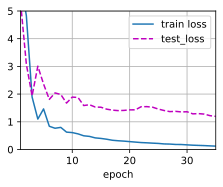

In [94]:
# Make sure the network weights are reset to small random values
alexnet.apply(init_weights)

# Train the network
train_net(alexnet, no_aug, no_aug, lr=0.0001, num_epochs=35)

## 2.3: Evaluation
Let's have a look at the predictions made by the network on the test data

**Exercise:**
* Run the two code blocks below to get the predictions on 10 training images
* What do you think of the quality of the bbox predictions?
* No change the second code block to evaluated on the test data instead.
* What do you think of the quality of the predictions on the test set? 
* How can you explain the observations?

In [71]:
def predict(net, X):
    net.eval()
    output = net(X.to(device))
    return output

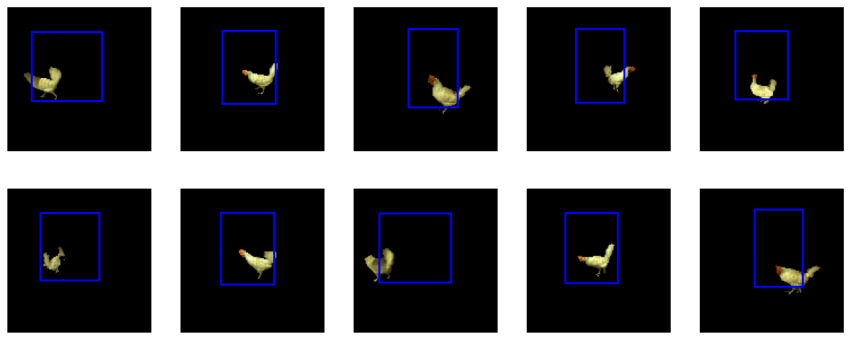

In [73]:
## TODO: change this to load the test data for evaluation
eval_loader = load_train_data(no_aug, batch_size=1)
eval_loader = load_test_data(no_aug, batch_size =1)
imgs= []
outputs = []

for index, (img, labels) in enumerate(eval_loader):
  pred_box = predict(alexnet, img)[0]
  # detach the tensor from the computational graph:
  box = pred_box.detach().cpu()
  outputs.append(box)
  imgs.append(to_pil_image(img[0]))
  if index == 10:
    break

plot_samples(imgs, outputs, 2, 5) 

# 3: Data augmentation 

It is clear that the training data and the test data are quite different. The chicken in the test data are much smaller than in the training data. In other words, **the training data is not representative for the test data**. As we have seen in the previous notebook, we can solve this using **data augmentation**.

**Exercise:**
* What kind of image augmentations would you propose to apply to the images in the training set?


##3.1: Image augmentation

Previously, we learned how to apply one or multiple augmentation methods to images only. In this tutorial, we will extend our knowledge and explore how to use image augmentations for both images and their corresponding bounding box annotations, to train a neural network.


**Exercise:**
* Standard torchvision transformations are limited to image transformation. Now, we will create our own class for custom augmentations.
* Study the code in the following block
* Look in lines 55-64. Which image transformations are applied to the image data? Do you think this will help to close the gap between training and test data?
* In line 35-53, a few random components are determined that are parameters of the image transformations. Which are these?



In [95]:
import random 
class CustomTransform:
    """
    Applies custom transformations to an image and its bounding box.
    """
    def __init__(self, p=0.5):
        """
        Initializes the transform.
        Args:
            p: float, probability of applying the transform (default: 0.5)
        """
        self.p = p
    
    def __call__(self, img, box):
        """
        Applies the transform to an image and its corresponding bounding box.
        Args:
            image: PIL.Image object, containing the original image.
            box: bounding box coordinates in the format [x, y, width, height].
        Returns:
            image_transformed: Tensor, containing the transformed image.
            box_transformed: the bounding box coordinates for the transformed box.
        """
        # transform image to tensor, if no augmentation is applied
        img_transformed = transforms.ToTensor()(img)
        box_transformed = box

        if random.random() < self.p:
            ###################
            # Get a few random components for transformations
            ###################

            # Apply a random scaling to the image, with a factor between 10-70% of the original
            scale = random.uniform(0.1, 0.7)
            new_height = new_width = int(img.size[0]*scale)
            # make sure size is an even number (simplifies padding):
            new_height = new_height if new_height % 2 == 0 else new_height+1
            new_width = new_width if new_width % 2 == 0 else new_width+1
            scale_adjusted = new_height/img.size[0]

            # Pad the resized image to maintain original image size 
            # Apply random amount of padding to the top/bottom, to randomly position the resized image in the new image
            padding = int((img.size[0]-new_height))
            padding_top = np.random.randint(padding)  
            padding_bottom = padding - padding_top
            padding_left = np.random.randint(padding)
            padding_right = padding - padding_left
            pad = [padding_left, padding_top, padding_right, padding_bottom]

            # In 50% of the cases (random) apply a horizontal flip
            do_flip = 1 if np.random.rand() > 0.5 else 0

            ###################
            # Apply the transformations:
            ###################
            image_transform = transforms.Compose([
              torchvision.transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1),
              torchvision.transforms.Resize((new_height, new_width)),
              torchvision.transforms.Pad(pad),
              transforms.RandomHorizontalFlip(p=do_flip),
              transforms.ToTensor()
            ])

            img_transformed = image_transform(img)
            box_transformed = box

        return img_transformed, box_transformed

Let's apply the custom augmentation to a random image of the training set. 

**Exercise:**
* Run the code below a few times to see results
* What do you think of the augmentations? Did we forget something?

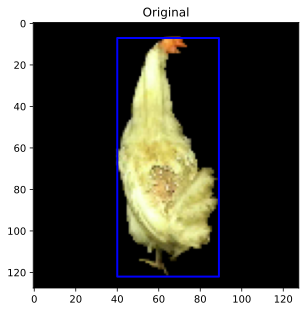

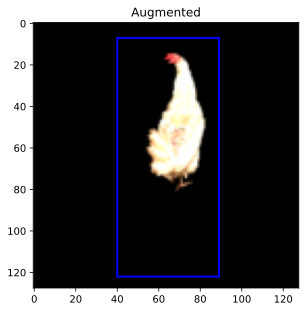

In [96]:
img_id = np.random.randint(len(train_dataset))

# Load and show the original image
image, box = train_dataset[img_id]
visualize_single_sample(image, box, "Original")

# Apply the image augmentation. Set probability of augmentation to 1, to make sure we see it
custom_transform = CustomTransform(p=1)
transformed_dataset = ChickenDataset(is_train=True,transforms=custom_transform)

# Visualize the results
image_transformed, box_transformed = transformed_dataset[img_id]
visualize_single_sample(to_pil_image(image_transformed), box_transformed, "Augmented")

## 3.2: Image and label augmentation

For image classificaiton, the augmentation applied to the image had no effect on the class. Hence, we did not need to change the label of the augmented training data. However, for **object localization, some image augmentations have an effect on the bounding-box coordinates**. 

**Exercise:**
* Look back in the augmentation that we applied in the `CustomTransform` class. Which of these transformation have an effect on the bbox coordinates and which do not?

**ANSWER:**
* The color jitter does not have an effect on the bounding box
* The random scaling, padding and flipping does change the coordinates of the bounding box.

We will define a new `CustomTransform` class to deal correctly with the bounding-box coordiantes. In the folowing code block, a skeleton of that class is provided. We now added the function `bbox_transform`.  

**Excercise:**
* Note that the following elements are important to consider
  * The bounding box coordinates in `transformed_box` and `box`:
    * `box[0]` is the x-position
    * `box[1]` is the y-position
    * `box[2]` is the width
    * `box[3]` is the height
  * The width of the image is in the variable `image_width`
  * The scaling factor applied in in the variable `scale`
  * The random padding is in the list `pad` important to consider are
    * `pad[0]`, the padding applied to the left side 
    * `pad[1]`, the padding applied to the top side
  * The variable `do_flip` is 1 if the horizontal flip was applied and other wise 0
* Complete the code of the ```bbox_transform``` function to transform the bounding boxes according to the given image transformation 



tensor([1.2341e+16, 4.5752e-41, 1.2341e+16, 4.5752e-41, 1.2341e+16, 4.5752e-41,
        1.2340e+16, 4.5752e-41, 1.2341e+16, 4.5752e-41])

In [105]:
import random 
class CustomTransform:
    """
    Applies custom transformations to an image and its bounding box.
    """
    def __init__(self, p=0.5):
        """
        Initializes the transform.
        Args:
            p: float, probability of applying the transform (default: 0.5)
        """
        self.p = p

    def bbox_transform(self, box, image_size, scale, pad, do_flip):
      """
        Transforms the bounding box coordinates.
        Args:
            box: bounding box coordinates in the format [x, y, width, height].
            image_size: size of the original image in the format (width, height).
            scale: scaling factor applied to the image.
            padding: amount of padding applied to the resized image.
        Returns:
            transformed_box: transformed bounding box coordinates.
        """
      # TODO: your custom bounding box transform code goes here:
      transformed_box = box 
      image_width, _ = image.size

      # Resize the boxes:
      transformed_box[0] = box[0] * scale + pad[0] 
      transformed_box[1] = box[1] * scale + pad[1]
      transformed_box[2] = box[2] * scale
      transformed_box[3] = box[3] * scale

      #Flip the boxes:
      if(do_flip):
        transformed_box[0]  = image_width - transformed_box[0]

      return transformed_box

    def __call__(self, img, box):
        """
        Applies the transform to an image and its corresponding bounding box.
        Args:
            image: PIL.Image object, containing the original image.
            box: bounding box coordinates in the format [x, y, width, height].
        Returns:
            image_transformed: Tensor, containing the transformed image.
            box_transformed: the bounding box coordinates for the transformed box.
        """
        # transform image to tensor, if no augmentation is applied
        img_transformed = transforms.ToTensor()(img)
        box_transformed = box

        if random.random() < self.p:
            ###################
            # Get a few random components for transformations
            ###################

            # Apply a random scaling to the image, with a factor between 10-70% of the original
            scale = random.uniform(0.1, 0.7)
            new_height = new_width = int(img.size[0]*scale)
            # make sure size is an even number (simplifies padding):
            new_height = new_height if new_height % 2 == 0 else new_height+1
            new_width = new_width if new_width % 2 == 0 else new_width+1
            scale_adjusted = new_height/img.size[0]

            # Pad the resized image to maintain original image size 
            # Apply random amount of padding to the top/bottom, to randomly position the resized image in the new image
            padding = int((img.size[0]-new_height))
            padding_top = np.random.randint(padding)  
            padding_bottom = padding - padding_top
            padding_left = np.random.randint(padding)
            padding_right = padding - padding_left
            pad = [padding_left, padding_top, padding_right, padding_bottom]

            # In 50% of the cases (random) apply a horizontal flip
            do_flip = 1 if np.random.rand() > 0.5 else 0

            ###################
            # Apply the transformations:
            ###################
            image_transform = transforms.Compose([
              torchvision.transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1),
              torchvision.transforms.Resize((new_height, new_width)),
              torchvision.transforms.Pad(pad),
              transforms.RandomHorizontalFlip(p=do_flip),
              transforms.ToTensor()
            ])

            img_transformed = image_transform(img)
            box_transformed = self.bbox_transform(box, img.size, scale_adjusted, pad, do_flip)  # transform bounding box

        return img_transformed, box_transformed




Now let's see if it is correct

**Exercise:**
* Run the code below a few times to make sure that your applied bbox transformation is correct.

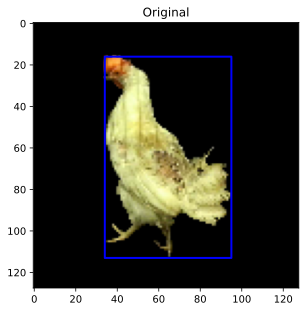

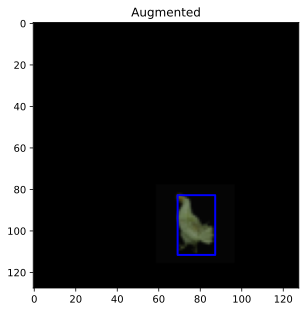

In [106]:
img_id = np.random.randint(len(train_dataset))

# Load and show the original image
image, box = train_dataset[img_id]
visualize_single_sample(image, box, "Original")

# Apply the image augmentation. Set probability of augmentation to 1, to make sure we see it
custom_transform = CustomTransform(p=1)
transformed_dataset = ChickenDataset(is_train=True,transforms=custom_transform)

# Visualize the results
image_transformed, box_transformed = transformed_dataset[img_id]
visualize_single_sample(to_pil_image(image_transformed), box_transformed, "Augmented")

# 4: AlexNet with data augmentation

## 4.1: Training
Let's train AlexNet again, but with augmentation this time.

We now have to load the CustomTransform class:

In [107]:
train_augs = CustomTransform(p=1.0)
test_augs = no_aug

And apply it during training.

**Exercise:**
* Train the network below
* Observe the development of training and test loss. What is your conclusion about the data augmentation applied?

train_loss 0.115
test_loss 0.194
11121.9 examples/sec on cuda:0


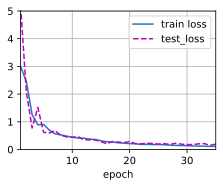

In [108]:
# Make sure the network has freshly initialized weights
alexnet.apply(init_weights)

# Train with data aug
train_net(alexnet, train_augs, test_augs, lr=0.0001, num_epochs=35)

## 4.2: Predicting
Let's have a look at the results

**Exercise:**
* Run the code below. What do you think of the predictions the network now makes?

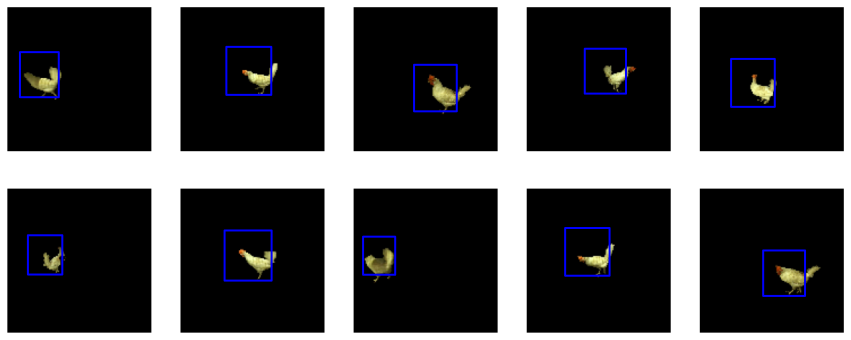

In [109]:
test_loader = load_test_data(test_augs, batch_size=1)
imgs= []
outputs = []

for index, (img, labels) in enumerate(test_loader):
  pred_box = predict(alexnet, img)[0]
  # detach the tensor from the computational graph:
  box = pred_box.detach().cpu()
  outputs.append(box)
  imgs.append(to_pil_image(img[0]))
  if index == 10:
    break

plot_samples(imgs, outputs, 2, 5) 

# 5: Conclusion

You have seen that it is important that the training data resembles the test data. As in this examples, that was not the case, you needed to apply data augmentations to scale and translate the images. However, that influenced not only the input to the network, but also the data labels. Therefore, you needed to apply data augmentation to the bounding box coordinates as well. With that in place, you have seen that the AlexNet can learn to locate the chickens in the images. 